# **Deteccion de imagenes generadas por IA usando deep y machine learning**


📌 Referencia para celdas de codigo que son auxiliares

🥷🏿 Referencia a celdas para codigo que no usa etiquetas

🏷️ Referencia a celdas para codigo que usa etiquetas

🚨 En la primera celda (Montar Drive), se debe cambiar la ruta a la carpeta personal de Drive donde están los archivos del proyecto.

✅ Despues de ejecutado el collab por primera vez, si se quiere trabajar sobre machine learning y clustering metods, solo hace falta ejecutar las celdas marcadas con este emoji, dado que los datos y modelos seran guardados en el drive personal de quien use el notebook




# Celdas auxiliares 📌

In [ ]:
#@title **MONTAR EL DRIVE**  📌🚨✅
import os
from google.colab import drive
drive.mount('/content/drive')
#ruta ='/content/drive/MyDrive/UIS/Inteligencia artificial 1/'
ruta = '/content/drive/MyDrive/INTELIGENCIA ARTIFICIAL/'
os.chdir(ruta)

Mounted at /content/drive


In [ ]:
import kagglehub
#@title Cargar librerias 1 📌✅
# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [ ]:
#@title Cargar librerias 2 📌✅
import numpy as np
import pandas as pd
import os
!pip install dill shap joblib
#plt.imshow((X_train[0]*255).astype("uint8"))

In [ ]:
#@title Cargar librerias 3 📌✅
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
import os
import numpy as np
from keras import Sequential
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Flatten, InputLayer, Reshape, Conv2DTranspose, BatchNormalization
# import kaggle
import zipfile
import torch
import joblib
import shap
import dill

In [ ]:
#@title Rutas del dataset 📌
folder_path = "/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3"
TRAIN_PATH = path+'/train'
TEST_PATH = path+'/test'

In [ ]:
#@title Funcion para cargar dataset 📌
def load_image_data(folder_path, label, target_size=(32, 32)):
    images = []
    labels = []
    total_files = len(os.listdir(folder_path))
    print(f"Loading {total_files} images from {folder_path}...")

    for i, img_name in enumerate(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            labels.append(label)

            # Print progress every 1000 images
            if (i+1) % 1000 == 0 or (i+1) == total_files:
                print(f"Loaded {i+1}/{total_files} images")

        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)


In [ ]:
#@title Carga de dataset y normalizar datos 📌
print("Loading training data...")
real_images, real_labels = load_image_data(os.path.join(TRAIN_PATH, 'REAL'), [0, 1])
fake_images, fake_labels = load_image_data(os.path.join(TRAIN_PATH, 'FAKE'), [1, 0])

print("Loading test data...")
test_real_images, test_real_labels = load_image_data(os.path.join(TEST_PATH, 'REAL'), [0, 1])
test_fake_images, test_fake_labels = load_image_data(os.path.join(TEST_PATH, 'FAKE'), [1, 0])

X_train = np.concatenate((real_images, fake_images)).astype('float32') / 255.0
y_train = np.concatenate((real_labels, fake_labels))
X_test = np.concatenate((test_real_images, test_fake_images)).astype('float32') / 255.0
y_test = np.concatenate((test_real_labels, test_fake_labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

Loading training data...
Loading 50000 images from /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL...
Loaded 1000/50000 images
Loaded 2000/50000 images
Loaded 3000/50000 images
Loaded 4000/50000 images
Loaded 5000/50000 images
Loaded 6000/50000 images
Loaded 7000/50000 images
Loaded 8000/50000 images
Loaded 9000/50000 images
Loaded 10000/50000 images
Loaded 11000/50000 images


KeyboardInterrupt: 

# Modelo supervisado 🏷️

In [ ]:
#@title Diseño de modelo convolucional supervisado 🏷️
def make_conv_model_s(learning_rate=1e-3, optimizer="adam", batchsize=32,):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
    ])


    # Learning rate scheduler
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=0.9)

    # Optimizer selection
    if optimizer.lower() == "adam":
        opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        opt = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    # Include 'precision' in the metrics list
    model.compile(
        optimizer=opt,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.Precision(), # Added precision metric
            keras.metrics.Recall()
        ])

    # Early stopping callback
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True)
    ]

    print('Training model...')
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batchsize,
        epochs=5,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return model

In [ ]:
#@title Crear modelo supervisado 🏷️
nonsupervised_model = make_conv_model_s()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Epoch 1/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - binary_accuracy: 0.7873 - loss: 0.4392 - precision: 0.7873 - recall: 0.7873 - val_binary_accuracy: 0.8986 - val_loss: 0.2445 - val_precision: 0.8986 - val_recall: 0.8986
Epoch 2/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - binary_accuracy: 0.9003 - loss: 0.2422 - precision: 0.9003 - recall: 0.9003 - val_binary_accuracy: 0.9020 - val_loss: 0.2314 - val_precision: 0.9020 - val_recall: 0.9020
Epoch 3/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - binary_accuracy: 0.9172 - loss: 0.2056 - precision: 0.9172 - recall: 0.9172 - val_binary_accuracy: 0.9174 - val_loss: 0.2097 - val_precision: 0.9174 - val_recall: 0.9174
Epoch 4/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - binary_accuracy: 0.9295 - loss: 0.1796 - precision: 0.9295 - recall: 0.9295 - val_binary_accuracy: 0.9137 - val_loss: 0.2142 - val_precision: 0.9137 - val_recall: 0.9137
Epoch 5/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.935

In [ ]:
#@title Guardar modelos convolucionales supervisados en drive 🏷️
from tensorflow.keras import Input, Model
model_input = Input(shape=(32, 32, 3))
x = model_input
for layer in nonsupervised_model.layers[:7]:  # toma las 7 capas del autoencoder
    x = layer(x)
conv_model = Model(inputs=model_input, outputs=x)
conv_model.save(ruta+'/Modelo_conv_flat_s.keras') # Guardar el modelo que genera el embebido, antes de pasarlo a una densa
nonsupervised_model.save(ruta+'/Modelo_conv_full_s.keras') # Guarda el modelo completo entrenado

In [ ]:
#@title Genera embebidos y los guarda en drive supervisado 🏷️
from tensorflow.keras.models import load_model
def generar_embebidos(path = ruta + 'Modelo_conv_flat_s.keras'):
  conv_model = load_model(path)
  X_train_embebido = conv_model.predict(X_train)
  X_test_embebido = conv_model.predict(X_test)

  #Aplana los datos porque no hubó capa flatten
  X_train_embebido = X_train_embebido.reshape(X_train_embebido.shape[0], -1)
  X_test_embebido = X_test_embebido.reshape(X_test_embebido.shape[0], -1)

  return X_train_embebido, X_test_embebido


X_train_flat, X_test_flat = generar_embebidos()
# Guardar como archivos separados
np.save(ruta + 'X_train_flat_s.npy', X_train_flat)
np.save(ruta + 'X_test_flat_s.npy', X_test_flat)
np.save(ruta + 'y_train_s.npy', y_train)
np.save(ruta + 'y_test_s.npy', y_test)

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
#@title Cargar embebidos de drive supervisado 🏷️✅
import numpy as np
X_train_flat_s = np.load(ruta + 'X_train_flat_s.npy')
X_test_flat_s = np.load(ruta + 'X_test_flat_s.npy')
y_train_s = np.load(ruta + 'y_train_s.npy')
y_test_s = np.load(ruta + 'y_test_s.npy')

In [ ]:
#@title Evaluar modelo supervisado con machine learning 🏷️✅
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluar_modelo_ml(nombre, modelo, X_train, y_train, X_test, y_test):
    print(f"\nModelo: {nombre}")
    modelo.fit(X_train, np.argmax(y_train, axis=1))
    y_pred = modelo.predict(X_test)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))

    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
    plt.title(f"Confusion Matrix - {nombre}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Modelos ML
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_lr = LogisticRegression(max_iter=1000)
modelo_svm = SVC(kernel='rbf')
modelo_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Evaluaciones
evaluar_modelo_ml("Random Forest", modelo_rf, X_train_flat_s, y_train_s, X_test_flat_s, y_test_s)
evaluar_modelo_ml("Logistic Regression", modelo_lr, X_train_flat_s, y_train_s, X_test_flat_s, y_test_s)
#evaluar_modelo_ml("SVM (RBF Kernel)", modelo_svm, X_train_flat_s, y_train_s, X_test_flat_s, y_test_s)
evaluar_modelo_ml("XGBoost", modelo_xgb, X_train_flat_s, y_train_s, X_test_flat_s, y_test_s)

# Modelo no supervisado 🥷🏿

In [ ]:
#@title Diseño de modelo convolucional no supervisado 🥷🏿

#Metricas para recontruccion de imagenes
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

#Arquitectura Autoencoder
def make_conv_model_non_s(learning_rate=1e-3, optimizer="adam", batchsize=32,):

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'),  # 4 → 8
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),   # 8 → 16
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),   # 16 → 32
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),   # 16 → 32
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # 32x32x3

    ])



    # Learning rate scheduler
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=0.9)

    # Optimizer selection
    if optimizer.lower() == "adam":
        opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        opt = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    # Include 'precision' in the metrics list
    model.compile(
        optimizer=opt,
        loss= 'mse',
        metrics=[
        ssim_metric,
        psnr_metric
          ])

    # Early stopping callback
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True)
    ]

    print('Training model...')
    history = model.fit(
        x=X_train,
        y=X_train,
        batch_size=batchsize,
        epochs=5,
        validation_data=(X_val, X_val),
        callbacks=callbacks,
        verbose=1
    )

    return model

In [ ]:
#@title Crear modelo no supervisado 🥷🏿
nonsupervised_model = make_conv_model_non_s()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Epoch 1/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0289 - psnr_metric: 16.4050 - ssim_metric: 0.3291 - val_loss: 0.0155 - val_psnr_metric: 18.7078 - val_ssim_metric: 0.4843
Epoch 2/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0150 - psnr_metric: 18.8946 - ssim_metric: 0.5030 - val_loss: 0.0134 - val_psnr_metric: 19.3874 - val_ssim_metric: 0.5351
Epoch 3/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0133 - psnr_metric: 19.4287 - ssim_metric: 0.5434 - val_loss: 0.0128 - val_psnr_metric: 19.6117 - val_ssim_metric: 0.5566
Epoch 4/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0125 - psnr_metric: 19.6930 - ssim_metric: 0.5674 - val_loss: 0.0121 - val_psnr_metric: 19.8525 - val_ssim_metric: 0.5778
Epoch 5/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0120 - psnr_metric: 19.8955 - ssim_metric: 0.5842 - val_loss: 0.0117 - val_psnr_metric: 19.9818 - val_ssim_metric: 0.5941


In [ ]:
#@title Guardar modelos convolucionales no supervisados en drive 🥷🏿
from tensorflow.keras import Input, Model
model_input = Input(shape=(32, 32, 3))
x = model_input
for layer in nonsupervised_model.layers[:6]:  #toma las 6 primeras capas del autoencoder, osea el encoder
    x = layer(x)
conv_model = Model(inputs=model_input, outputs=x)
conv_model.save(ruta+'/Modelo_conv_flat_non_s.keras') #Guarda el encoder
nonsupervised_model.save(ruta+'/Modelo_conv_full_non_s.keras') #Guarda el autoencoder

In [ ]:
#@title Genera embebidos y los guarda en drive (no supervisado) 🥷🏿
from tensorflow.keras.models import load_model
def generar_embebidos(path = ruta + 'Modelo_conv_flat_non_s.keras'):
  conv_model = load_model(path)
  X_train_embebido = conv_model.predict(X_train)
  X_test_embebido = conv_model.predict(X_test)

  X_train_embebido = X_train_embebido.reshape(X_train_embebido.shape[0], -1)
  X_test_embebido = X_test_embebido.reshape(X_test_embebido.shape[0], -1)

  return X_train_embebido, X_test_embebido


X_train_flat, X_test_flat = generar_embebidos()
# Guardar como archivos separados
np.save(ruta + 'X_train_flat_non_s.npy', X_train_flat)
np.save(ruta + 'X_test_flat_non_s.npy', X_test_flat)
np.save(ruta + 'y_train_non_s.npy', y_train)
np.save(ruta + 'y_test_non_s.npy', y_test)

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(32, 32, 3)
(32, 32, 3)


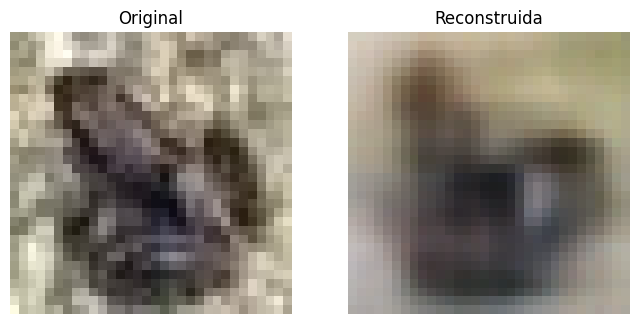

In [ ]:
#@title Mostrar imagen y reconstruccion de autoencoder no supervisado 🥷🏿✅
from tensorflow.keras.models import load_model

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def comparar_original_reconstruccion(mymodel):
  import matplotlib.pyplot as plt
  import numpy as np

  # Entrada original
  original = np.load(ruta + 'Imagen prueba.npy')

  # Reconstrucción del modelo
  reconstructed = mymodel.predict(np.expand_dims(original, axis=0))[0]  # Quitar el batch con [0]

  print(original.shape)
  print(reconstructed.shape)

  # Mostrar ambas
  plt.figure(figsize=(8, 4))

  plt.subplot(1, 2, 1)
  plt.imshow(original)
  plt.title("Original")
  plt.axis("off")
  plt.subplot(1, 2, 2)
  plt.imshow(reconstructed)
  plt.title("Reconstruida")
  plt.axis("off")
  plt.show()

conv_model = load_model(ruta + 'Modelo_conv_full_non_s.keras', custom_objects={'ssim_metric': ssim_metric, 'psnr_metric':psnr_metric})
comparar_original_reconstruccion(conv_model)

In [ ]:
#@title Cargar embebidos de drive (no supervisado) 🥷🏿✅
import numpy as np
X_train_flat_non_s = np.load(ruta + 'X_train_flat_non_s.npy')
X_test_flat_non_s = np.load(ruta + 'X_test_flat_non_s.npy')
y_train_non_s = np.load(ruta + 'y_train_non_s.npy')
y_test_non_s = np.load(ruta + 'y_test_non_s.npy')

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



KMeans + PCA
  Clusters encontrados: 2
  Silhouette Score: 0.339
  Calinski-Harabasz Score: 51356.805
  Davies-Bouldin Score: 1.164

DBSCAN + PCA
  Clusters encontrados: 3
  Silhouette Score: 0.348
  Calinski-Harabasz Score: 25.962
  Davies-Bouldin Score: 3.373

KMeans + t-SNE
  Clusters encontrados: 2
  Silhouette Score: 0.999
  Calinski-Harabasz Score: 509996.312
  Davies-Bouldin Score: 0.000

DBSCAN + t-SNE: Clustering inválido (solo 1 clúster o todos ruido)


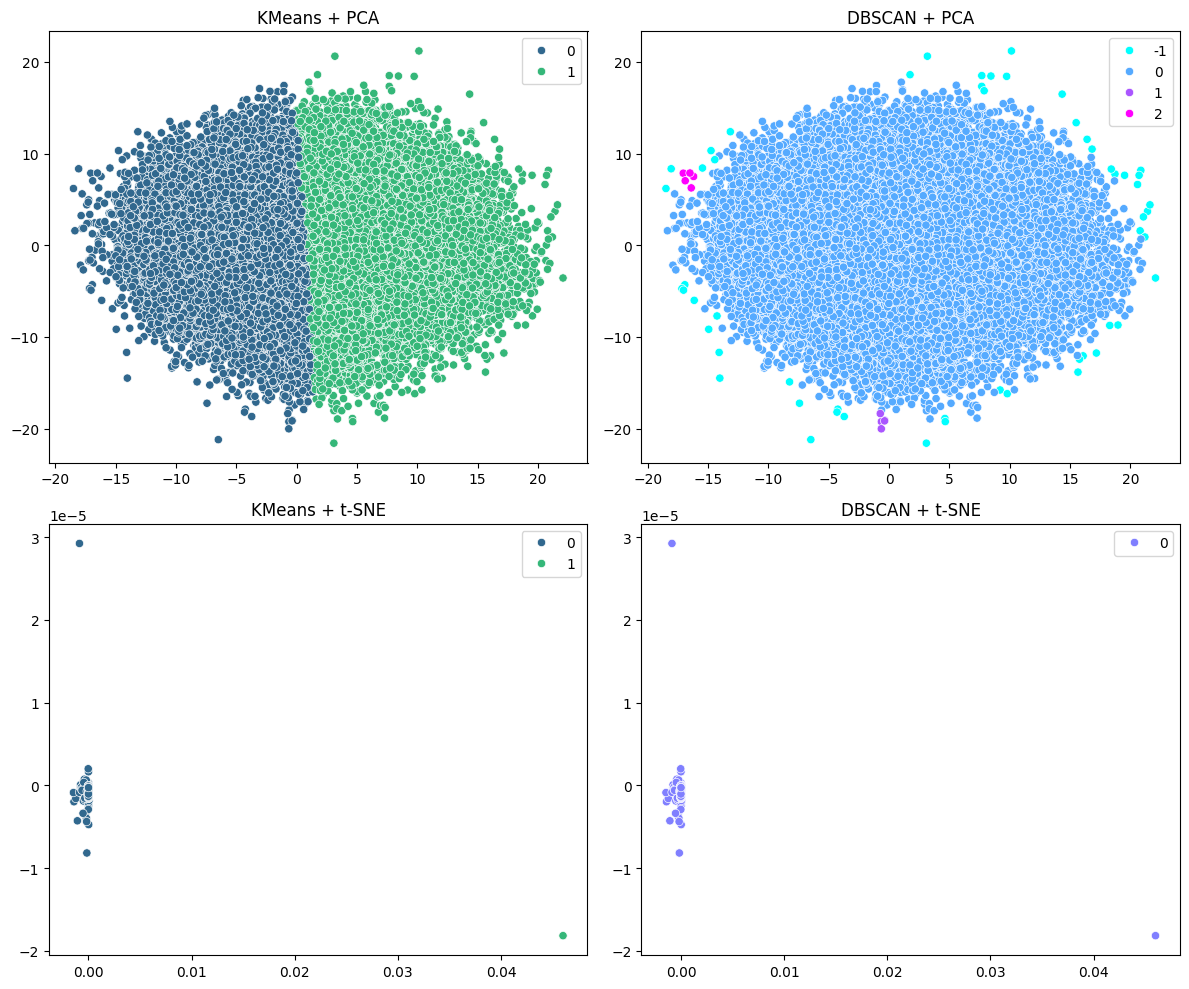

In [ ]:
#@title Poner a prueba los metodos (no supervisado) 🥷🏿✅
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

# Preprocesamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_flat_non_s)

# Reducción con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Reducción con t-SNE (con subset si es muy grande)
X_subset = X_scaled[:5000]
tsne = TSNE(n_components=2, perplexity=30, n_iter=250, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

# Clustering
kmeans_pca = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)
dbscan_pca = DBSCAN(eps=1, min_samples=5).fit_predict(X_pca)

kmeans_tsne = KMeans(n_clusters=2, random_state=42).fit_predict(X_tsne)
dbscan_tsne = DBSCAN(eps=1, min_samples=5).fit_predict(X_tsne)

# Función para imprimir métricas
def print_metrics(X, labels, name):
    unique_labels = set(labels)
    if len(unique_labels) > 1 and len(unique_labels) < len(X):
        sil = silhouette_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)
        print(f"\n{name}")
        print(f"  Clusters encontrados: {len(set(labels)) - (1 if -1 in labels else 0)}")
        print(f"  Silhouette Score: {sil:.3f}")
        print(f"  Calinski-Harabasz Score: {ch:.3f}")
        print(f"  Davies-Bouldin Score: {db:.3f}")
    else:
        print(f"\n{name}: Clustering inválido (solo 1 clúster o todos ruido)")

# Mostrar métricas
print_metrics(X_pca, kmeans_pca, "KMeans + PCA")
print_metrics(X_pca, dbscan_pca, "DBSCAN + PCA")
print_metrics(X_tsne, kmeans_tsne, "KMeans + t-SNE")
print_metrics(X_tsne, dbscan_tsne, "DBSCAN + t-SNE")

# Visualización
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_pca, palette='viridis', ax=axs[0, 0])
axs[0, 0].set_title("KMeans + PCA")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_pca, palette='cool', ax=axs[0, 1])
axs[0, 1].set_title("DBSCAN + PCA")

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_tsne, palette='viridis', ax=axs[1, 0])
axs[1, 0].set_title("KMeans + t-SNE")

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=dbscan_tsne, palette='cool', ax=axs[1, 1])
axs[1, 1].set_title("DBSCAN + t-SNE")

plt.tight_layout()
plt.show()


In [ ]:
#@title Poner a prueba los metodos (no supervisado) metricas de Accuracy, Precision y Recall 🥷🏿✅

from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.stats import mode
import numpy as np

# Funcion para mapear etiquetas de clustering a etiquetas verdaderas
def map_cluster_labels(pred_labels, true_labels):
    labels = np.zeros_like(pred_labels)
    for i in np.unique(pred_labels):
        if i == -1:  # Ignorar outliers en DBSCAN
            continue
        mask = pred_labels == i
        if np.any(mask):
            labels[mask] = mode(true_labels[mask], keepdims=True)[0]
    return labels

# Funcion para imprimir métricas
def print_classification_metrics(true, pred, name):
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    rec = recall_score(true, pred)
    print(f"\n{name} - Métricas Supervisadas")
    print(f"  Accuracy:  {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall:    {rec:.3f}")

# Convertir etiquetas one-hot a etiquetas simples
y_train_non_s = np.argmax(y_train, axis=1)        # PCA
y_subset = np.argmax(y_train[:5000], axis=1)      # t-SNE

# Aplicar mapeo de etiquetas y evaluar para PCA
mapped_kmeans_pca = map_cluster_labels(kmeans_pca, y_train_non_s)
mapped_dbscan_pca = map_cluster_labels(dbscan_pca, y_train_non_s)

print_classification_metrics(y_train_non_s, mapped_kmeans_pca, "KMeans + PCA")
print_classification_metrics(y_train_non_s, mapped_dbscan_pca, "DBSCAN + PCA")

# Aplicar mapeo de etiquetas y evaluar para t-SNE
mapped_kmeans_tsne = map_cluster_labels(kmeans_tsne, y_subset)
mapped_dbscan_tsne = map_cluster_labels(dbscan_tsne, y_subset)

print_classification_metrics(y_subset, mapped_kmeans_tsne, "KMeans + t-SNE")
print_classification_metrics(y_subset, mapped_dbscan_tsne, "DBSCAN + t-SNE")
print_classification_metrics(y_subset, mapped_kmeans_tsne, "KMeans + t-SNE")
print_classification_metrics(y_subset, mapped_dbscan_tsne, "DBSCAN + t-SNE")

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions